# Contributions

Inspiration for these plots and analysis follows from {cite:t}`marra_advancing_2023` and {cite:t}`sweet_implications_2024`, which use the nonstationary GEV analysis of {cite:t}`mendez_analyzing_2007` to analyze the influence of climatic patterns like ENSO and PDO (for example) on extreme sea levels. This notebook changes only one aspect of the method - allowing for a lagged covariate in the nonstationary GEV model.  

## Setup

First we'll import the necessary functions, set up our directories, and get everything ready for plotting.

In [1]:
%run setup.ipynb
%run plotting_functions.ipynb
import json
from scipy.stats import chi2
import sys
cwd = os.getcwd()
base_dir = os.path.abspath(os.path.join(cwd, "../"))  # For interactive mode (Jupyter/IPython)
pythonPath = os.path.join(base_dir, 'python', 'nonstationaryGEV')
sys.path.append(pythonPath)
sys.path.append(os.path.join(base_dir, 'python'))

from imports import make_directoryDict
from helpers import adjust_w_for_plotting
from maps import plot_thin_map_hawaii, get_stationinfo


# set up directories to read from
dirs = make_directoryDict(base_dir)

from matplotlib import colors, cm
from matplotlib.lines import Line2D


### Compile data 
Before running this, you will need to run the non-stationary models. In the following codes we are just compiling the output and results from those models that have been saved to "model_output_dir" directory. The methodology contained herein follows {cite:t}`sweet_implications_2024`.

#### Choose station and climate indices
Here we'll use all tested indices

In [2]:
climateIndex = ['AO','BEST','ONI','PDO','PMM','PNA','TNA']

# get list of all directories in dirs['model_output_dir']
dirs_list = os.listdir(dirs['model_output_dir'])

# only keep the directories that are numbers
recordIDs = [int(d) for d in dirs_list if d.isdigit()]


# get station names from the best_params.json files
station_names = {}
for recordID in recordIDs:
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'best_params.json'
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        station_names[recordID] = output['modelInfo']['station_name']

# sort the station names by the recordID
station_names = {k: v for k, v in sorted(station_names.items(), key=lambda item: item[0])}

station_names

{50: 'Midway',
 52: 'Johnston',
 57: 'Honolulu, Hawaii',
 58: 'Nawiliwili',
 59: 'Kahului',
 60: 'Hilo, Hawaii',
 61: 'Mokuoloe',
 552: 'Kawaihae'}

#### Create a dataframe
This will hold information about the amplitude of the tested climate index signals in the location parameter of the best-fit nonstationary GEV model.

In [3]:
#%%
for recordID in recordIDs:
    # Initialize an empty list to store results
    results = []
    SignifCvte1 = np.zeros(len(climateIndex))
    w_nodal = np.zeros(len(climateIndex))
    w_cvte1 = np.zeros(len(climateIndex))

    for i in np.arange(0, len(climateIndex)):
        #read first value of w from trend_params.json
        nodal_params = 'nodal_params.json'
        jsonpath = Path(dirs['model_output_dir']) / str(recordID) / nodal_params
        with open(jsonpath, 'r') as f:
            output = json.load(f)
            w_nodal[i] = output['w'][0]

        covariate_params = f'cvte_location_params_{climateIndex[i]}.json'

        # Create the full path for the JSON file
        jsonpath = Path(dirs['model_output_dir']) / str(recordID) / covariate_params

        # Open and read the JSON file
        with open(jsonpath, 'r') as f:
            output = json.load(f)
        w, mio, standard_error,x = (np.array(output[key]) for key in ['w', 'mio', 'standard_error','x'])

        wfull = adjust_w_for_plotting(x,w)

        # prepend standard error with 0 to match the size of w
        standard_error = np.insert(standard_error, 0, 0)

        standard_error = adjust_w_for_plotting(x,standard_error)

        # Store the results in a list
        results.append({
            'Climate Index': climateIndex[i],
            'CI param': wfull[10],  
            'Standard Error of CI param': standard_error[10]
        })

        # Compute deviance statistic
        w_cvte1[i] = w[0]
        diffe = w_cvte1[i] - w_nodal[i]
        p = 1
        SignifCvte1[i] = chi2.cdf(2 * diffe, p)

    # Convert the results list to a DataFrame
    df_cvteLocation = pd.DataFrame(results)

    # add Significance to the dataframe
    df_cvteLocation['Significance (over Nodal)'] = SignifCvte1


    # add the lags from CI_correlation_results.csv
    CI_correlation_results = pd.read_csv(Path(dirs['CI_dir']) / 'CI_correlation_results_v2.csv')

    #rename climateIndex to Climate Index
    CI_correlation_results = CI_correlation_results.rename(columns={'climateIndex':'Climate Index'})
    
    # extract only the reocrdID of interest
    CI_corr = CI_correlation_results[CI_correlation_results['recordID'] == recordID]
    
    # add the lags from CI_correlation_results['lag'] to df_cvteLocation, matching on Climate Index and recordID
    df_cvteLocation = df_cvteLocation.merge(CI_corr[['Climate Index','lag']], on='Climate Index')


    #save to a json file
    df_cvteLocation.to_json(Path(dirs['model_output_dir']) / str(recordID) / 'cvte_location_params_ALL.json')
    df_cvteLocation


#### Plot the parameter magnitudes

First let's take a look at an example dataframe showing the influence of each climate index as covariate in the nonstationary GEV model.

In [4]:
recordID = 57
df_cvteLocation = pd.read_json(Path(dirs['model_output_dir']) / str(recordID) / 'cvte_location_params_ALL.json')
df_cvteLocation

,Climate Index,CI param,Standard Error of CI param,Significance (over Nodal),lag
0,AO,0.011489,0.004334,0.992358,26
1,BEST,0.027613,0.003459,1.000000,18
2,ONI,0.023994,0.003319,1.000000,18
3,PDO,0.026923,0.004178,1.000000,16
4,PMM,0.018782,0.003680,1.000000,10
5,PNA,0.004901,0.004816,0.621647,11
6,TNA,0.007613,0.004441,0.919458,0


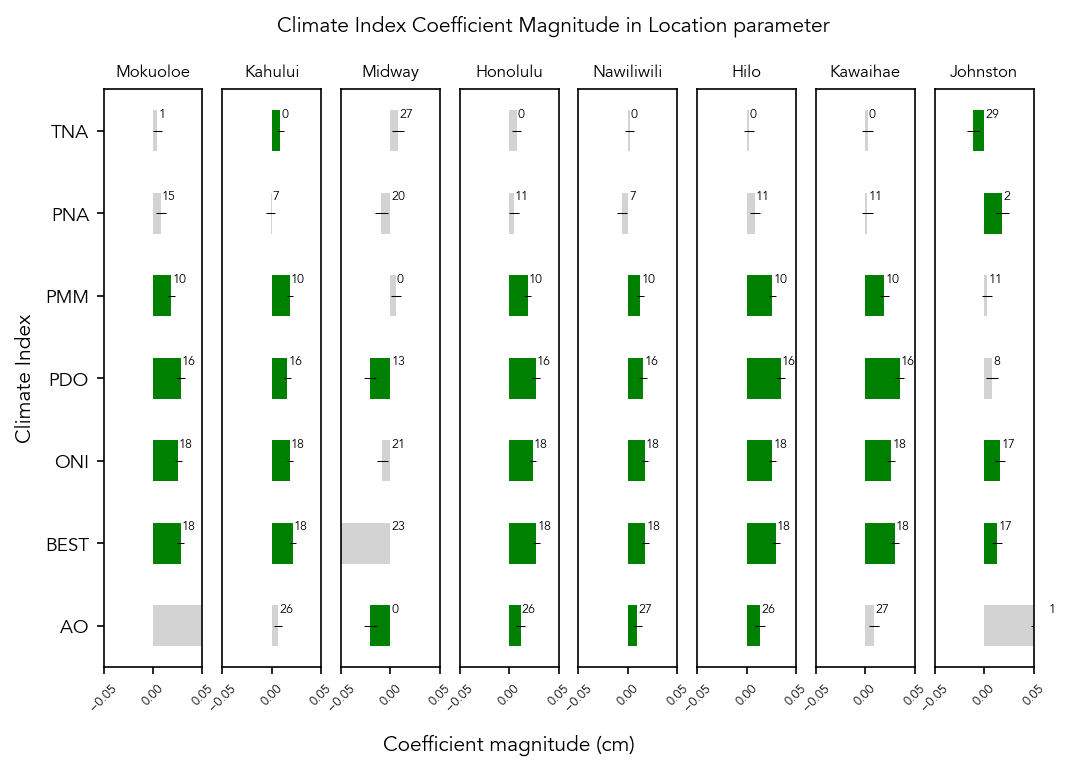

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig,ax = plt.subplots(1,8,figsize=(8,5))

for i,recordID in enumerate(recordIDs):
     
    station_name = station_names[recordID]
    # Create the full path for the JSON file
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'cvte_location_params_ALL.json'

     # Open and read the JSON file
    with open(jsonpath, 'r') as f:
        output = json.load(f)
    
    df_cvteLocation = pd.DataFrame(output)

    # Define colors based on significance
    location_colors = np.where(df_cvteLocation['Significance (over Nodal)']>0.95, 'green', 'lightgray')


    # Plot the Location parameter with custom colors for significance
    df_cvteLocation.plot(
        x='Climate Index',
        y='CI param',
        kind='barh',  # Horizontal bar plot
        ax=ax[i],
        color=location_colors
    )

    # add error bars
    ax[i].errorbar(df_cvteLocation['CI param'], df_cvteLocation.index, 
                   xerr=df_cvteLocation['Standard Error of CI param'], fmt='none', ecolor='black', capsize=0, lw =0.5)
    
    # add lag to each bar
    
    halign = 'left'
    for j in range(len(df_cvteLocation)):
        xoffset = 0.001
        if df_cvteLocation['CI param'].iloc[j]<0:
            xoffset = -df_cvteLocation['CI param'].iloc[j]+xoffset
        ax[i].text(df_cvteLocation['CI param'].iloc[j]+xoffset, j+0.2, '{:.0f}'.format(df_cvteLocation['lag'].iloc[j]), fontsize=6, ha=halign, va='center', color='black')


    ax[i].legend().set_visible(False)

    # Remove y-axis label
    ax[i].set_ylabel('')

    # remove x-tick labels
    if i != 0:
        ax[i].set_yticklabels([])
        ax[i].set_yticks([])

    # set all axes to the same scale
    ax[i].set_xlim(-0.05,0.05)

    # set xticks to have only 3 ticks
    ax[i].set_xticks(np.linspace(-0.05,0.05,3))

    # rotate xticks
    ax[i].tick_params(axis='x', rotation=45)

    # set fontsize of xticks
    ax[i].tick_params(axis='x', labelsize=6)
    ax[i].set_title(station_name.split(',')[0].strip(), fontsize=8)

    # add super title
    fig.suptitle('Climate Index Coefficient Magnitude in Location parameter', fontsize=10)

    # add y label to full plot
    ax[0].set_ylabel('Climate Index', fontsize=10)

    # add x label to full plot
    ax[3].set_xlabel('Coefficient magnitude (cm)', fontsize=10, labelpad=10)


# glue figure
glue("CI_mag_inLocation",fig,display=False)

plt.savefig(output_dir / 'CI_mag_location.png', dpi=300, bbox_inches='tight')




```{glue:figure} CI_mag_inLocation
:name: "CI_mag_inLocation"

A comparison of the magnitudes of the climate index covariate in the location parameter of the nonstationary GEV model. The tested climate indices are shown in green when their inclusion in the total model (after the inclusion of the nodal cycle) is considered a significant contribution. Coefficients which do not offer a significant improvement over the Nodal model are shown in gray. The lag (in months) is shown next to each bar plot. Note that for this run, we have held the PMM index at a 10 month lag ({cite:t}`long_higher_2020` uses 8-month lag for upper 100m), PDO at 16 months, and ONI and BEST at 18 months for the Hawaiian Island stations ({cite:t}`long_higher_2020` find a 19-month lag for Niño3). Johnston and Midway are considered to be far enough away from the Hawaiian Island chain to have their own respective lags.
```

Note that here PDO, BEST, PMM and ONI all have the same lag if they are Hawaiian Island stations. This is a fixed lag based on average results across all stations and/or pre-existing literature. I'm doing this for consistency across the region. 

For the record, we can look at the original "best" lags from the original correlation output file.

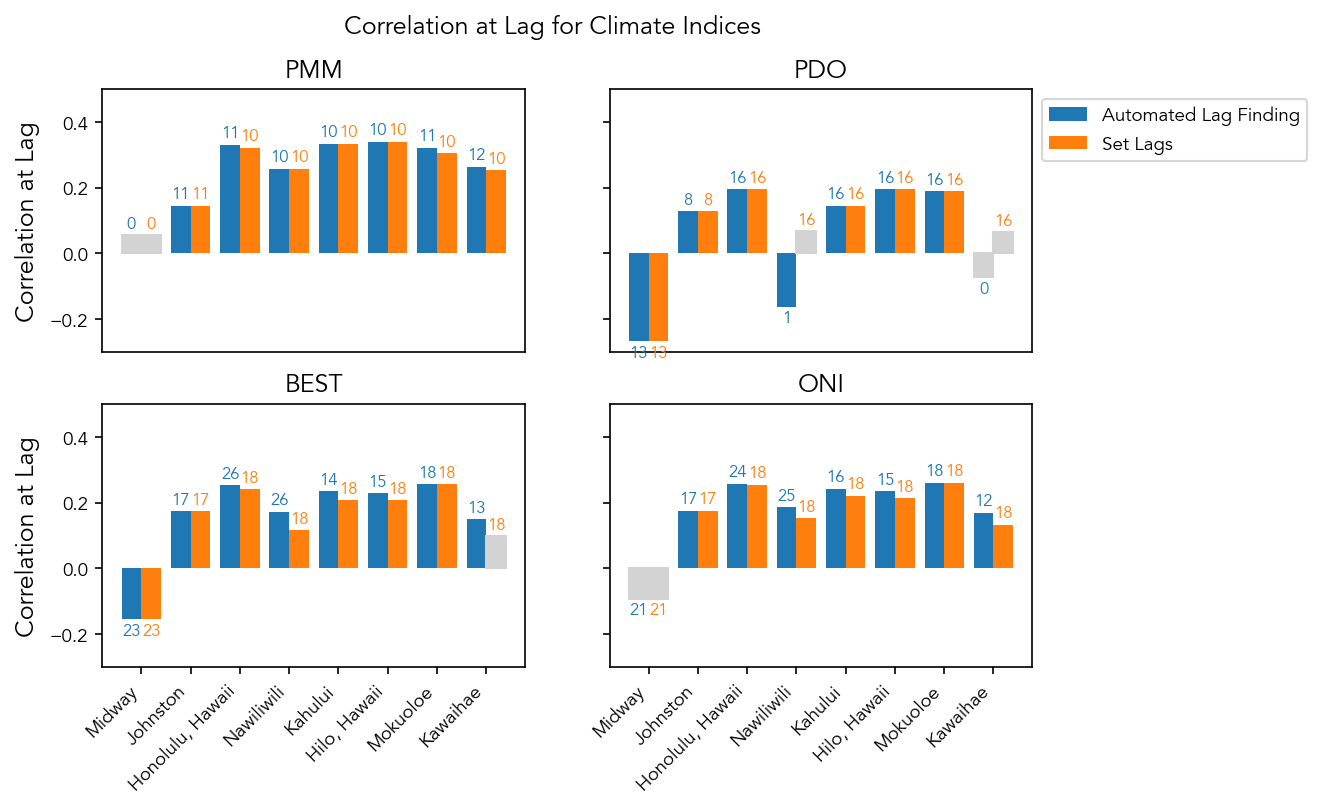

In [6]:
# Load data
dfLagsOriginal = pd.read_csv(Path(dirs['CI_dir']) / 'CI_correlation_results.csv')
dfLagsSet = pd.read_csv(Path(dirs['CI_dir']) / 'CI_correlation_results_v2.csv')

CInames = ['PMM','PDO','BEST','ONI']

def barlabel(ax, bar, lag, yoffset=0.01):
    if bar.get_height() > 0:
        yoffset = 0.01
        valign = 'bottom'
    else:
        yoffset = -0.01
        valign = 'top'

    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + yoffset, f'{int(lag)}', 
                ha='center', va=valign, fontsize=8, color=bar.get_facecolor())
    

# Plot the bars side by side
fig, axes = plt.subplots(2, 2, figsize=(8, 5))

for i, CIname in enumerate(CInames):
    ax = axes.flatten()[i]
    CIname = CInames[i]

    dfLagsCI_1 = dfLagsOriginal[dfLagsOriginal['climateIndex'].isin([CIname])]
    dfLagsCI_2 = dfLagsSet[dfLagsSet['climateIndex'].isin([CIname])]

    # Define bar width
    width = 0.4  

    # Create numerical x positions for stations
    stations = dfLagsCI_1['station'].unique()
    x = np.arange(len(stations))  # Numeric x positions



    bars1 = ax.bar(x - width/2, dfLagsCI_1['max_corr'], width, label='Automated Lag Finding', align='center')
    bars2 = ax.bar(x + width/2, dfLagsCI_2['max_corr'], width, label='Set Lags', align='center')

    for j, bar in enumerate(bars1):
        barlabel(ax, bar, dfLagsCI_1['lag'].iloc[j])
        barlabel(ax, bars2[j], dfLagsCI_2['lag'].iloc[j])

    # make the bars transparent if they are not significant
    for j, bar in enumerate(bars1):
        if dfLagsCI_1['significant'].iloc[j] == 0:
            bar.set_color('lightgray')
    for j, bar in enumerate(bars2):
        if dfLagsCI_2['significant'].iloc[j] == 0:
            bar.set_color('lightgray')
                


    # Set x-axis labels to station names
    if i>1:
        ax.set_xticks(x)
        ax.set_xticklabels(stations, rotation=45, ha='right')
    else:
        # Remove x-axis labels
        ax.set_xticks([])
        ax.set_xticklabels([])

    if i==1:
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    if i==0 or i==2:
        ax.set_ylabel('Correlation at Lag')
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')

    # Add labels and legend
    ax.set_title(CIname)

    # set y-axis limits
    ax.set_ylim(-0.3,0.5)


fig.suptitle('Correlation at Lag for Climate Indices', fontsize=12)

glue("CI_lag_correlation",fig,display=False)


```{glue:figure} CI_lag_correlation
:name: "CI_lag_correlation"

In this plot we examine the differences between holding the lag constant for the four climate indices shown, or allowing the algorithm to find the peak correlation automatically. For PMM, there is little change in correlation between using the set or auto lag. Likewise with PDO, with the exception of Nawiliwili and Kawaihae. In examining the full lagged correlations for these two stations, it is clear that for both stations PDO is less correlated in general when compared to other climate indices.
```

#### Plot all models
Next we'll look at all models and how they compare.

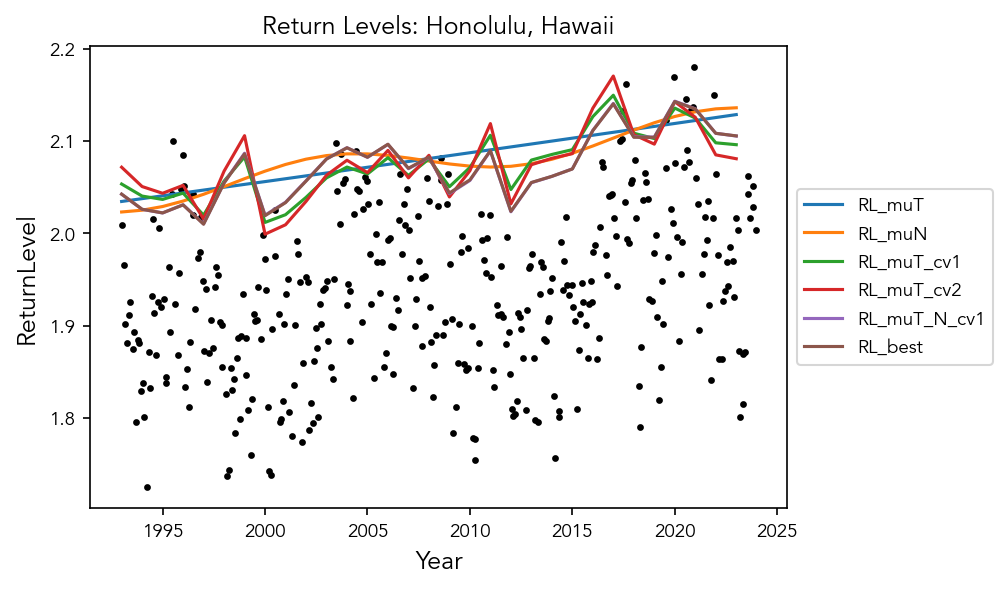

In [7]:
# Only do Honolulu for now
# recordID = '59_new'
recordID = 57

modelTypes = ['RL_muT', 'RL_muN','RL_muT_cv1','RL_muT_cv2','RL_muT_N_cv1','RL_muT_N_cv2','RL_best']

for modelType in modelTypes:
    modelName = modelType + '.nc'
    modelPath = Path(dirs['model_output_dir'] / str(recordID) / modelName)

    if not modelPath.exists():
        continue
    model = xr.open_dataset(modelPath)

    model['ReturnLevel'].sel(ReturnPeriod=2).plot(label=modelType)

plt.legend()
# put the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# read the json file for best model
jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'best_params.json'
with open(jsonpath, 'r') as f:
    output = json.load(f)
    modelInfo = output['modelInfo']
    params = output['w']
    x = output['x']

time = modelInfo['year0'] + pd.Series(modelInfo['t'])
plt.scatter(time, modelInfo['monthlyMax'], color='k', label='Monthly Maxima', s=5)

plt.title('Return Levels: ' + model.attrs['station_name'])

w = adjust_w_for_plotting(x, params)

### Plot Components in time
First we'll make a function for plotting.

In [8]:
def plot_location(w, modelInfo, label, offset=0, component=True):
    # Unpack the w array
    b0, b1, b2, b3, b4, b5, b6 = w[0], w[3], w[4], w[5], w[6], w[7], w[8]
    a0, bLT, bCI, aCI, bN1, bN2 = w[1], w[9], w[10], w[11], w[12], w[13]

    # Check if w[10] (bCI) is zero (i.e., no covariate contribution)
    if bCI == 0:
        ti = np.arange(0, modelInfo['t'][-1], 0.01)
        CI = 0  # Covariate is zero if bCI is zero
    else:
        ti = pd.Series(modelInfo['t']) 
        CI = pd.Series(modelInfo['covariate'])  # Covariate values

        

    # Make sure CI and ti are aligned (if CI is a series)
    if isinstance(CI, pd.Series) and len(CI) != len(ti):
        raise ValueError("Length of covariate CI does not match the length of ti.")

    # Define mut (location(t)) as a function of ti and CI
    mut = (b0 * np.exp(bLT * ti) +
           b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
           b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
           b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti) +
           bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
           (bCI * CI))  

    # Calculate the amplitudes for each harmonic and the covariate
    amp_annual = np.sqrt(b1**2 + b2**2)      # First harmonic (annual cycle)
    amp_semiannual = np.sqrt(b3**2 + b4**2)  # Second harmonic (semiannual cycle)
    amp_third = np.sqrt(b5**2 + b6**2)       # Third harmonic (quarterly or 8π cycle)
    amp_nodal = np.sqrt(bN1**2 + bN2**2)     # Nodal component
    amp_covariate = abs(bCI)                 # Covariate amplitude
    amp_trend = 0.5*(b0 * np.exp(bLT * modelInfo['t'][-1]) - b0*np.exp(bLT * modelInfo['t'][0]))  # Trend amplitude



    amp_seasonal = np.sqrt(amp_annual**2 + amp_semiannual**2 + amp_third**2)
    
    # Calculate the total amplitude
    amp = np.sqrt(amp_seasonal**2 + amp_nodal**2 + amp_covariate**2 + amp_trend**2)
    


    # Subtract the datum offset
    mut = mut - modelInfo['STNDtoMHHW']

    if component:
        mut_demeaned = mut - np.mean(mut)
    else:
        mut_demeaned = mut
    
    # mut_demeaned = mut_demeaned - modelInfo['STNDtoMHHW']
    
    # add zero line for reference in gray
    plt.axhline(y=offset, color='gray', linestyle='-.', alpha=0.5)

    # Plot the result

    plt.plot(ti+modelInfo['year0'], mut_demeaned + offset, label=label + ' (' + str(round(2*amp*100, 2)) + ' cm)') 
    return amp



Then we'll make a function for making the figure.

In [9]:
# Make figure
def make_component_figure(w, modelInfo, model, time):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    returnYear = 10

    # Add returnYear-year return level to the plot
    plt.plot(model['Year']+0.5, 
            model['ReturnLevel'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'], 
            label=f'{returnYear}-year Return Level', color='black', linewidth=2) 

    # add error bars as shaded area from model['RL_low'] to model['RL_high']
    plt.fill_between(model['Year']+0.5, 
                    model['RL_high'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'], 
                    model['RL_low'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'],
                    color='gray', alpha=0.2)

    # Add monthly maxima, centered
    mm = np.array(modelInfo['monthlyMax']) - modelInfo['STNDtoMHHW']
    plt.scatter(time, mm, color='gray', label='Monthly Maxima', s=5)
    amp_full = plot_location(w, modelInfo, label='Full $\mu(t)$', offset=0, component=False)

    # First plot: Covariate contribution
    wnew = np.zeros(len(w))
    wnew[10] = w[10]  # Only use the covariate component
    offset1 = -0.2  # Offset for the plot
    amp_CI = plot_location(wnew, modelInfo, label=modelInfo['covariateName'] , offset=offset1)


    # Second plot: Seasonal components
    wnew = np.zeros(len(w))
    wnew[1:9] = w[1:9]  # Seasonal components
    offset1 -= 0.2  # Increment offset correctly
    amp_S = plot_location(wnew, modelInfo, label='Seasonal', offset=offset1)

    # Third plot: Long-term trend
    wnew = np.zeros(len(w))
    wnew[9] = w[9]  # Long-term trend component
    wnew[0] = w[0]  # Plus base value
    offset1 -= 0.2  # Increment offset correctly
    amp_LT = plot_location(wnew, modelInfo, label='Long-term trend', offset=offset1)


    # Fourth plot: Nodal component
    wnew = np.zeros(len(w))
    wnew[12:14] = w[12:14]  # Nodal components
    offset1 -= 0.2  # Increment offset correctly
    amp_N = plot_location(wnew, modelInfo, label='Nodal', offset=offset1)

    plt.title('Location Parameter Components: ' + model.attrs['station_name'])
    plt.xlim(modelInfo['t'][0] + modelInfo['year0'], modelInfo['t'][-1] + modelInfo['year0'])
    plt.ylabel('Height above MHHW (m)')

    # Add legend to the outside of the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.subplots_adjust(right=0.85)

    # add a second y-axis on the right side to label components
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(np.arange(0, offset1-0.2, -0.2))
    ax2.set_yticklabels([' Full $\mu(t)$', ' ' +
                      modelInfo['covariateName'] + ' $\mu_{CI}(t)$' , 
                      ' Seasonal $\mu_{S}(t)$', 
                      ' Long-term trend $\mu_{LT}(t)$', 
                      ' Nodal $\mu_{N}(t)$']); #not sure why there's output here but I've suppressed it  
    
    amps = [amp_full, amp_CI, amp_S, amp_LT, amp_N]
    amp_names = ['Full', 'Covariate', 'Seasonal', 'Long-term trend', 'Nodal']

        # Get the default color cycle
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
#     x_line_position = ax.get_xlim()[1] + 0.5
    x_line_position = 0.86
    y_ticks = ax2.get_yticks()
    # Draw vertical lines on the figure using figure-relative coordinates
    for i, amp in enumerate(amps):
        ymin_fig = ax2.transData.transform((0, y_ticks[i] - amp))[1]  # Bottom of the line
        ymax_fig = ax2.transData.transform((0, y_ticks[i] + amp))[1]  # Top of the line
        ymin_norm = fig.transFigure.inverted().transform((0, ymin_fig))[1]  # Convert to figure normalized
        ymax_norm = fig.transFigure.inverted().transform((0, ymax_fig))[1]  # Convert to figure normalized
        
        # Plot vertical line in figure coordinates
        fig.lines.append(plt.Line2D([x_line_position, x_line_position], [ymin_norm, ymax_norm],
                                    transform=fig.transFigure, solid_capstyle='round',
                                    color = color_cycle[i],linestyle='-', linewidth=3))


    amps = dict(zip(amp_names, amps))
    return fig, amps, ax


Finally, we'll plot it up!

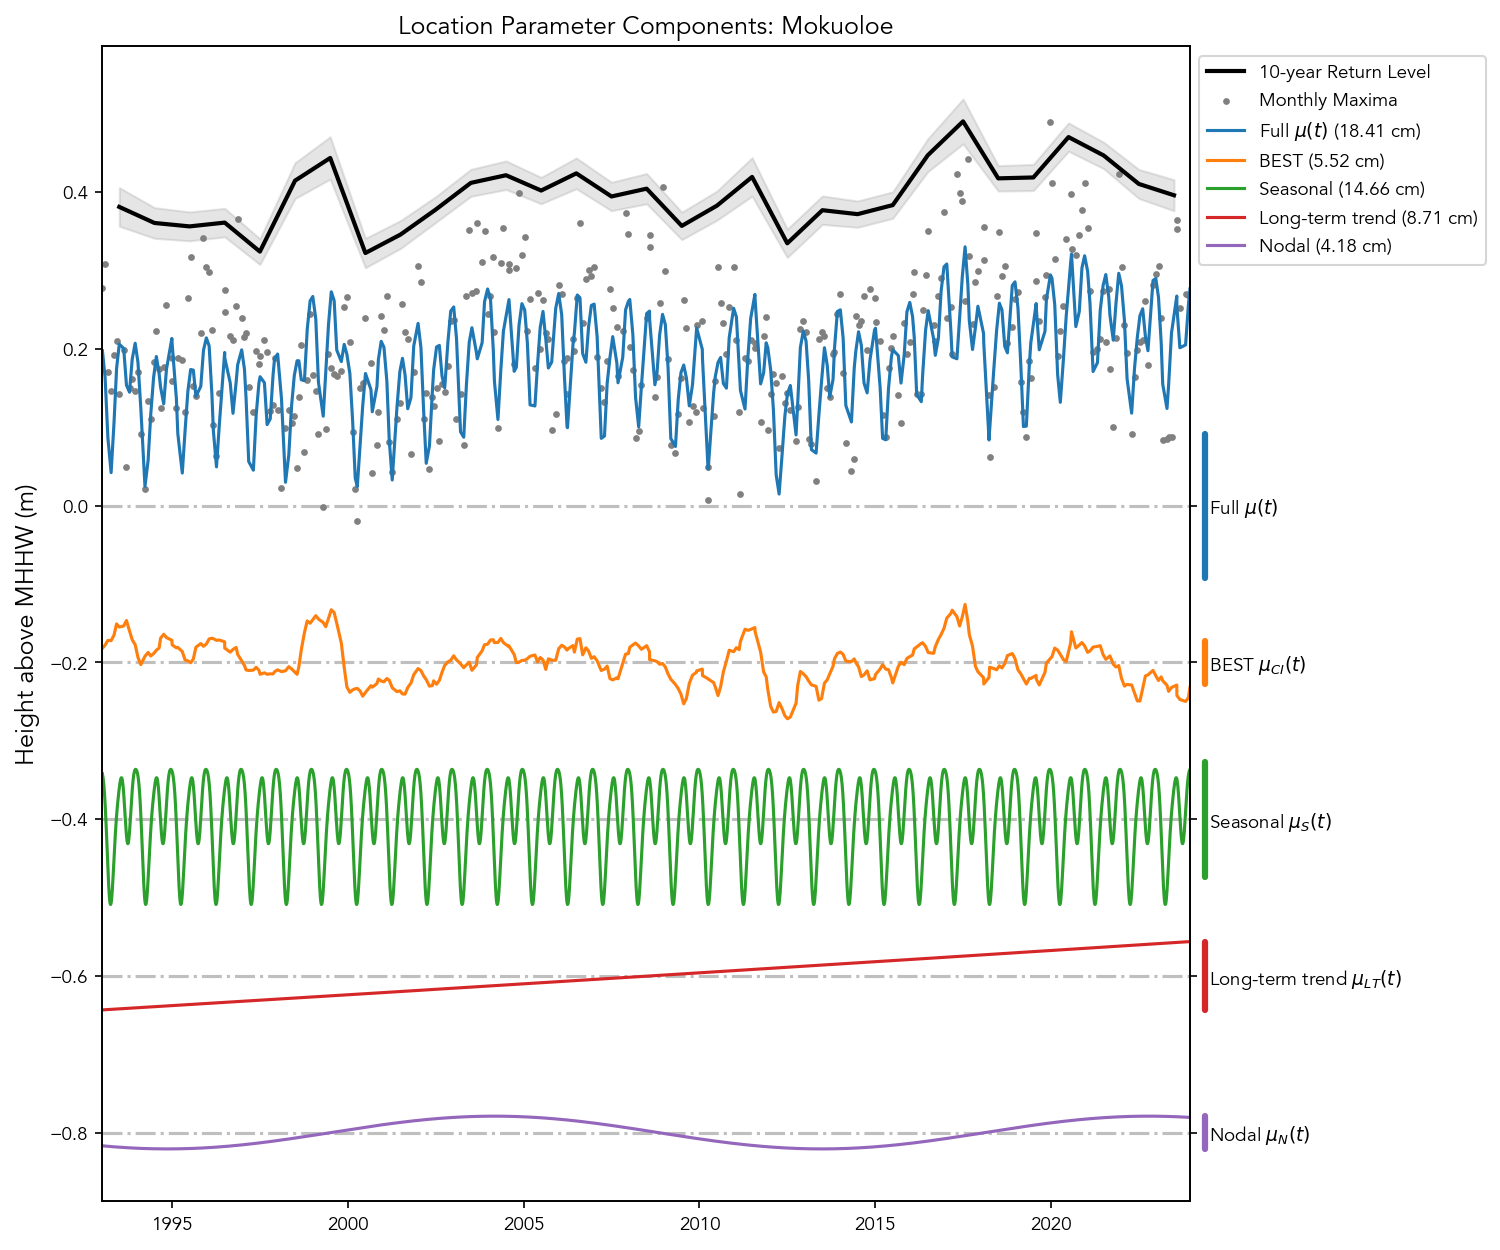

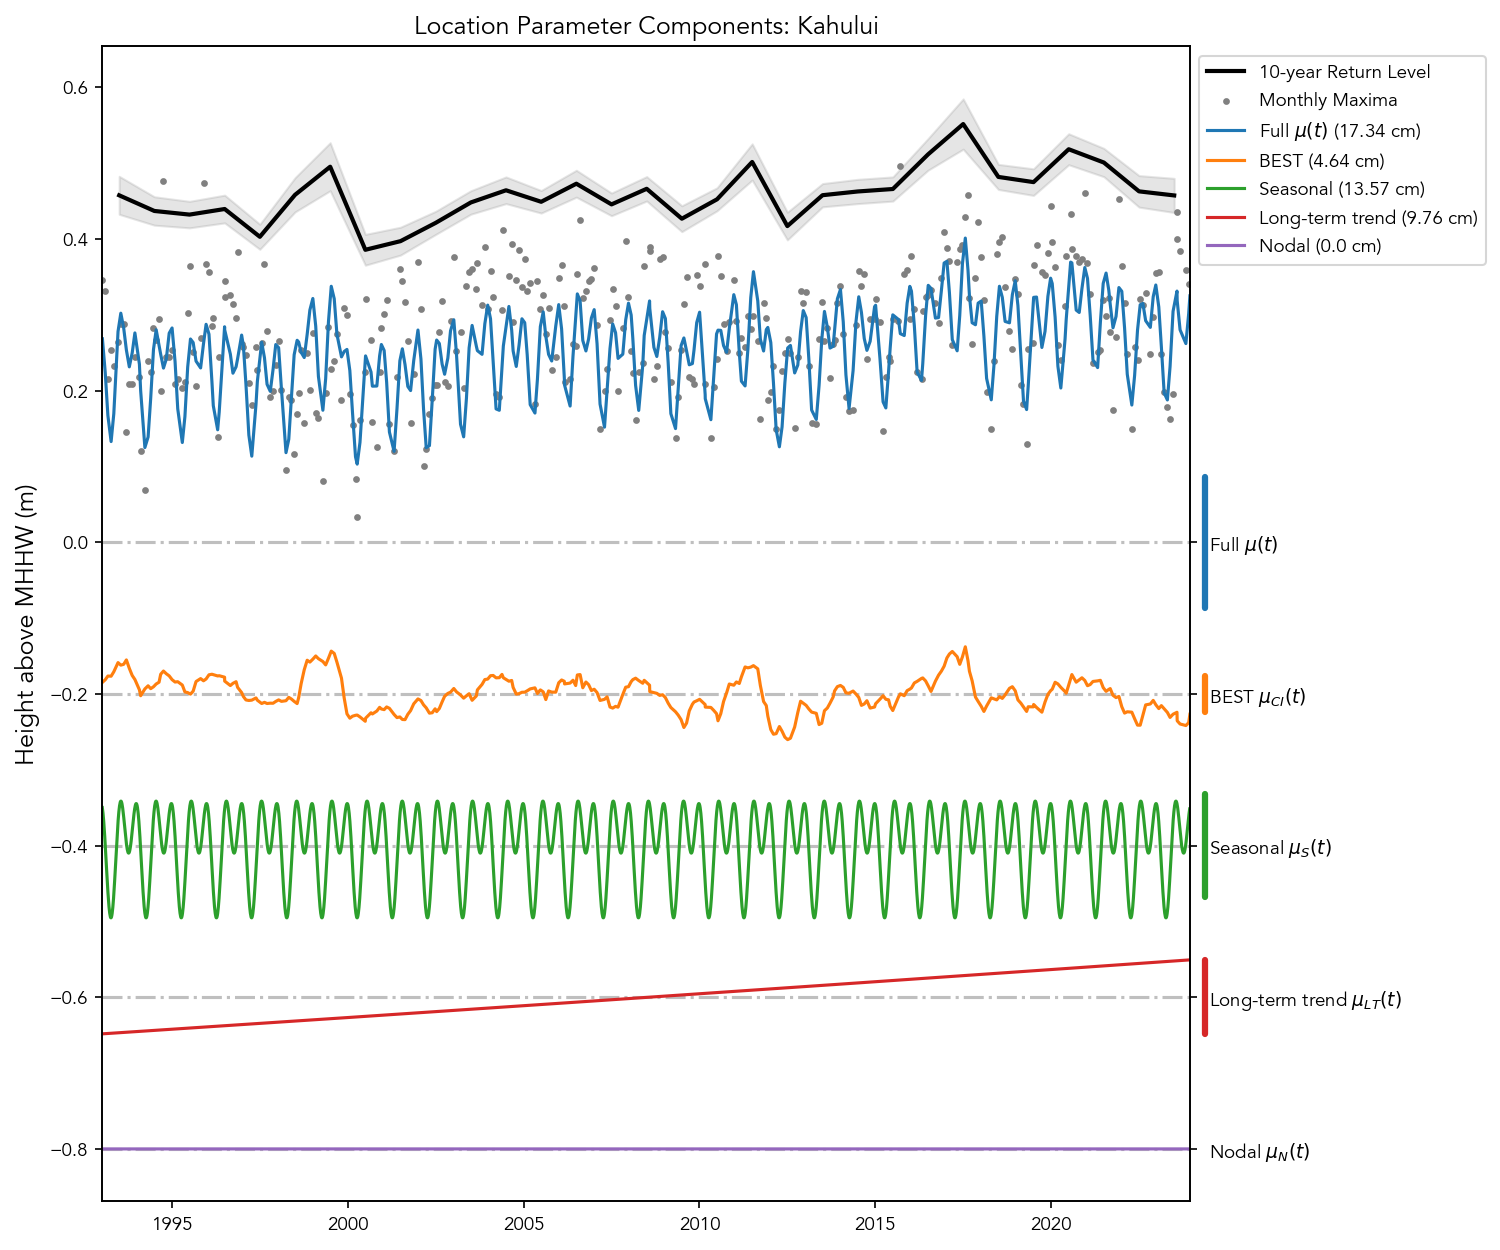

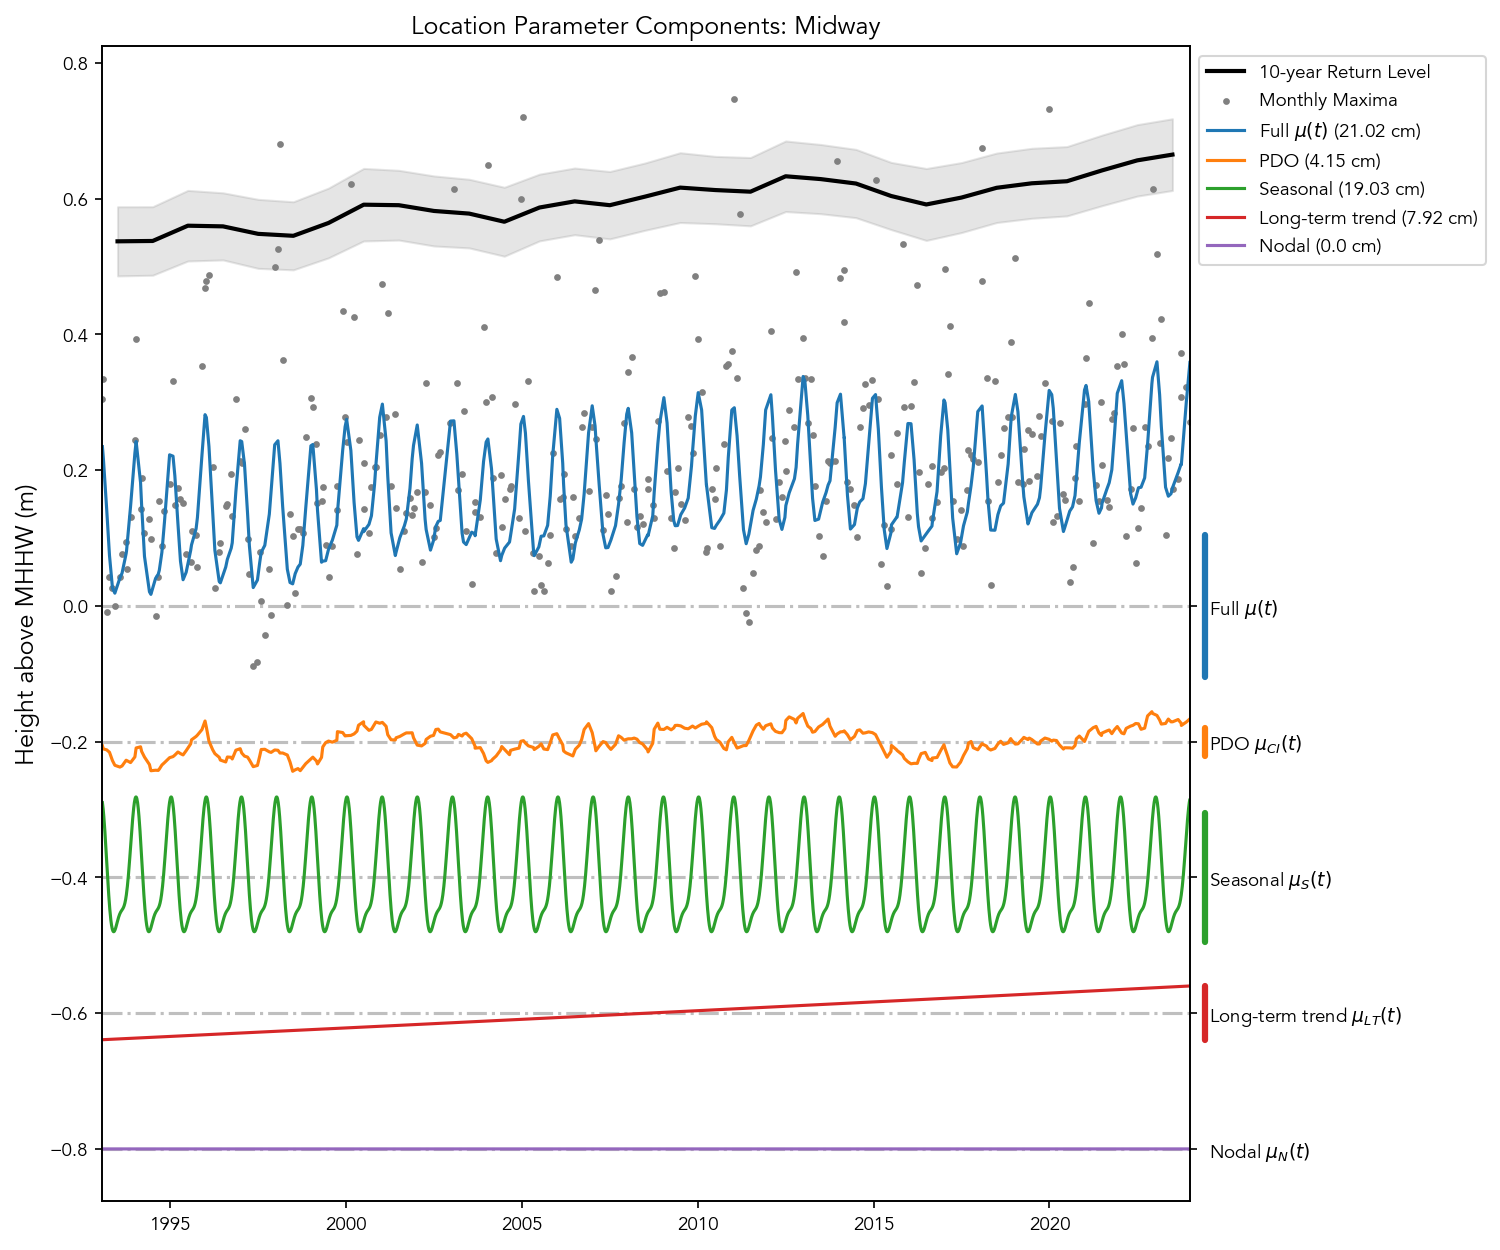

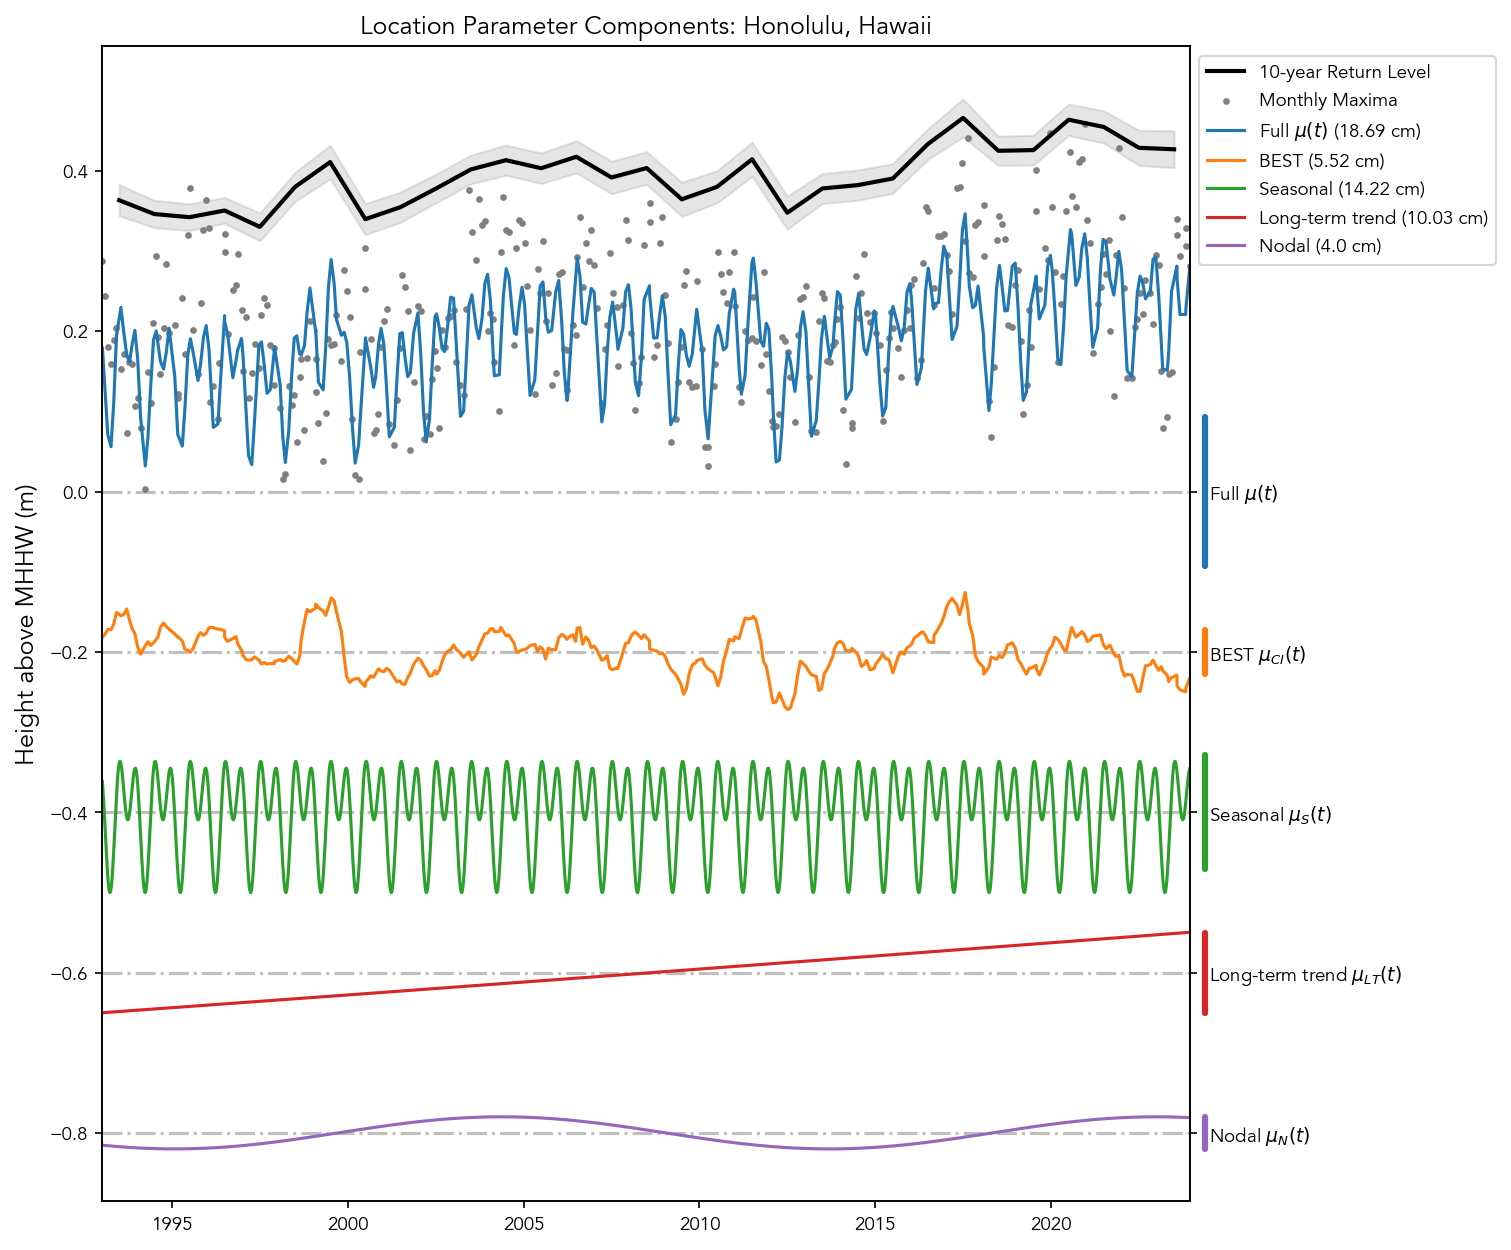

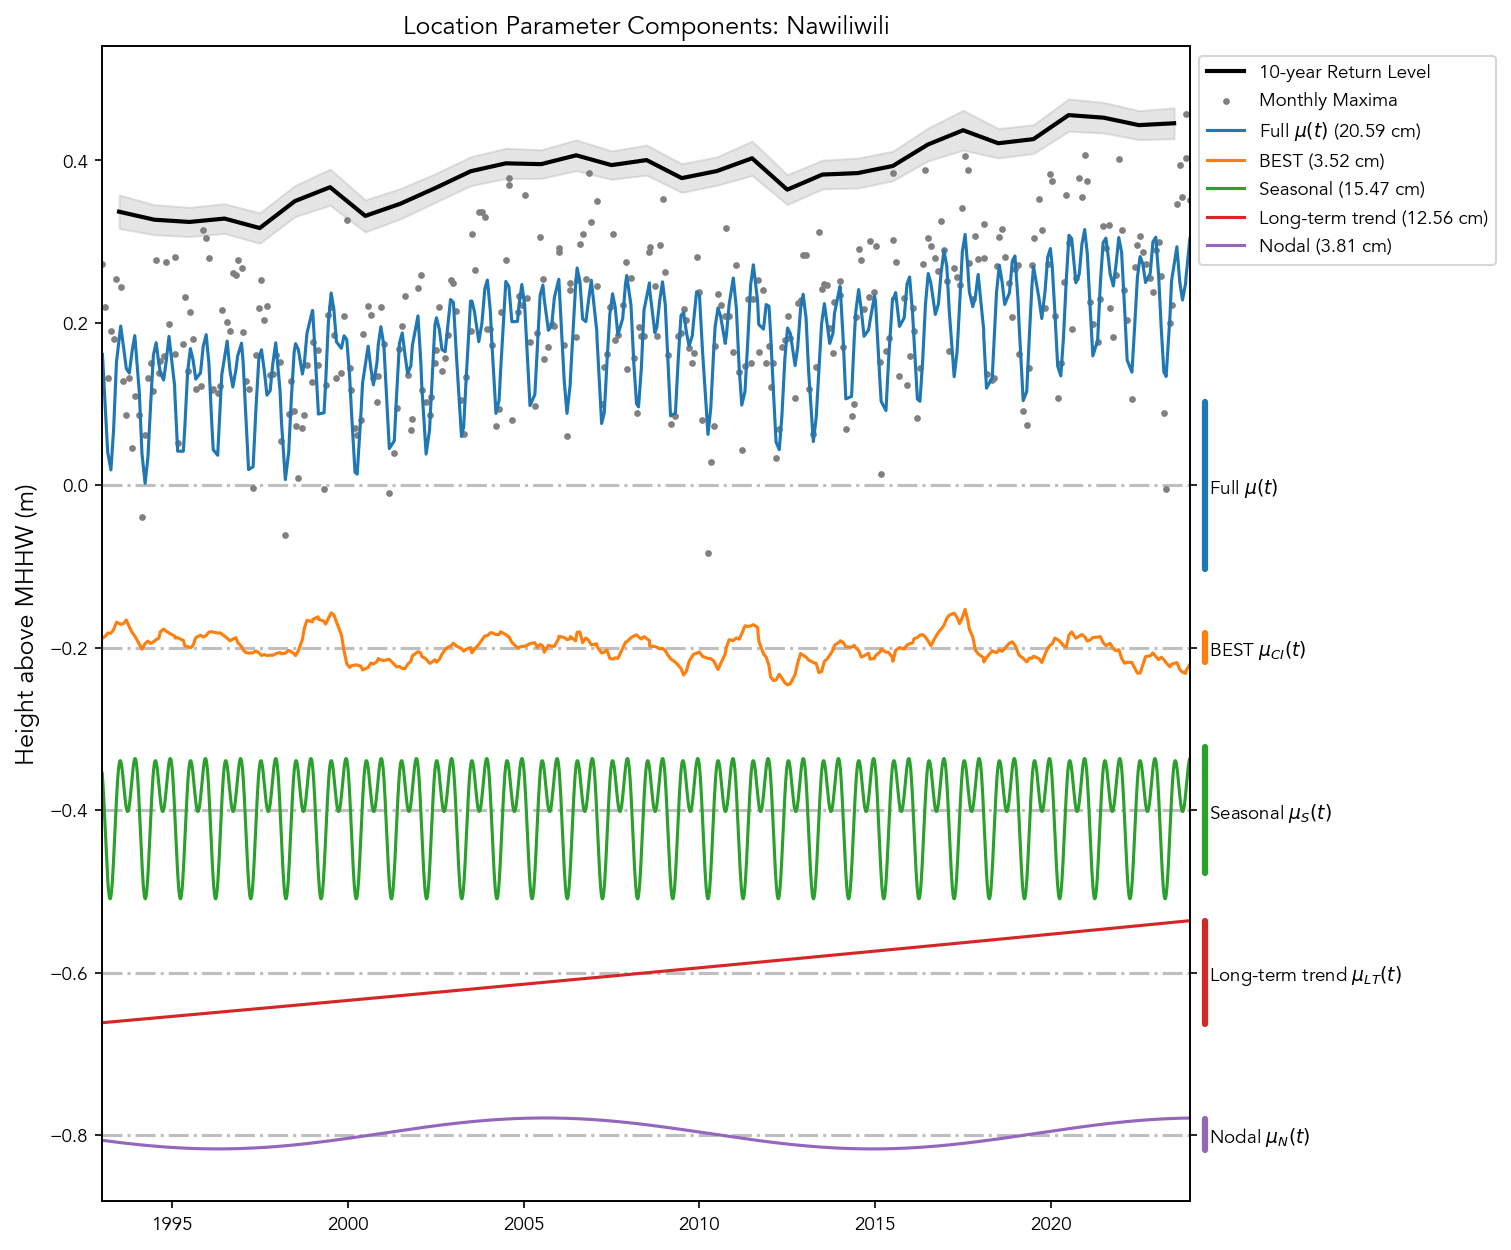

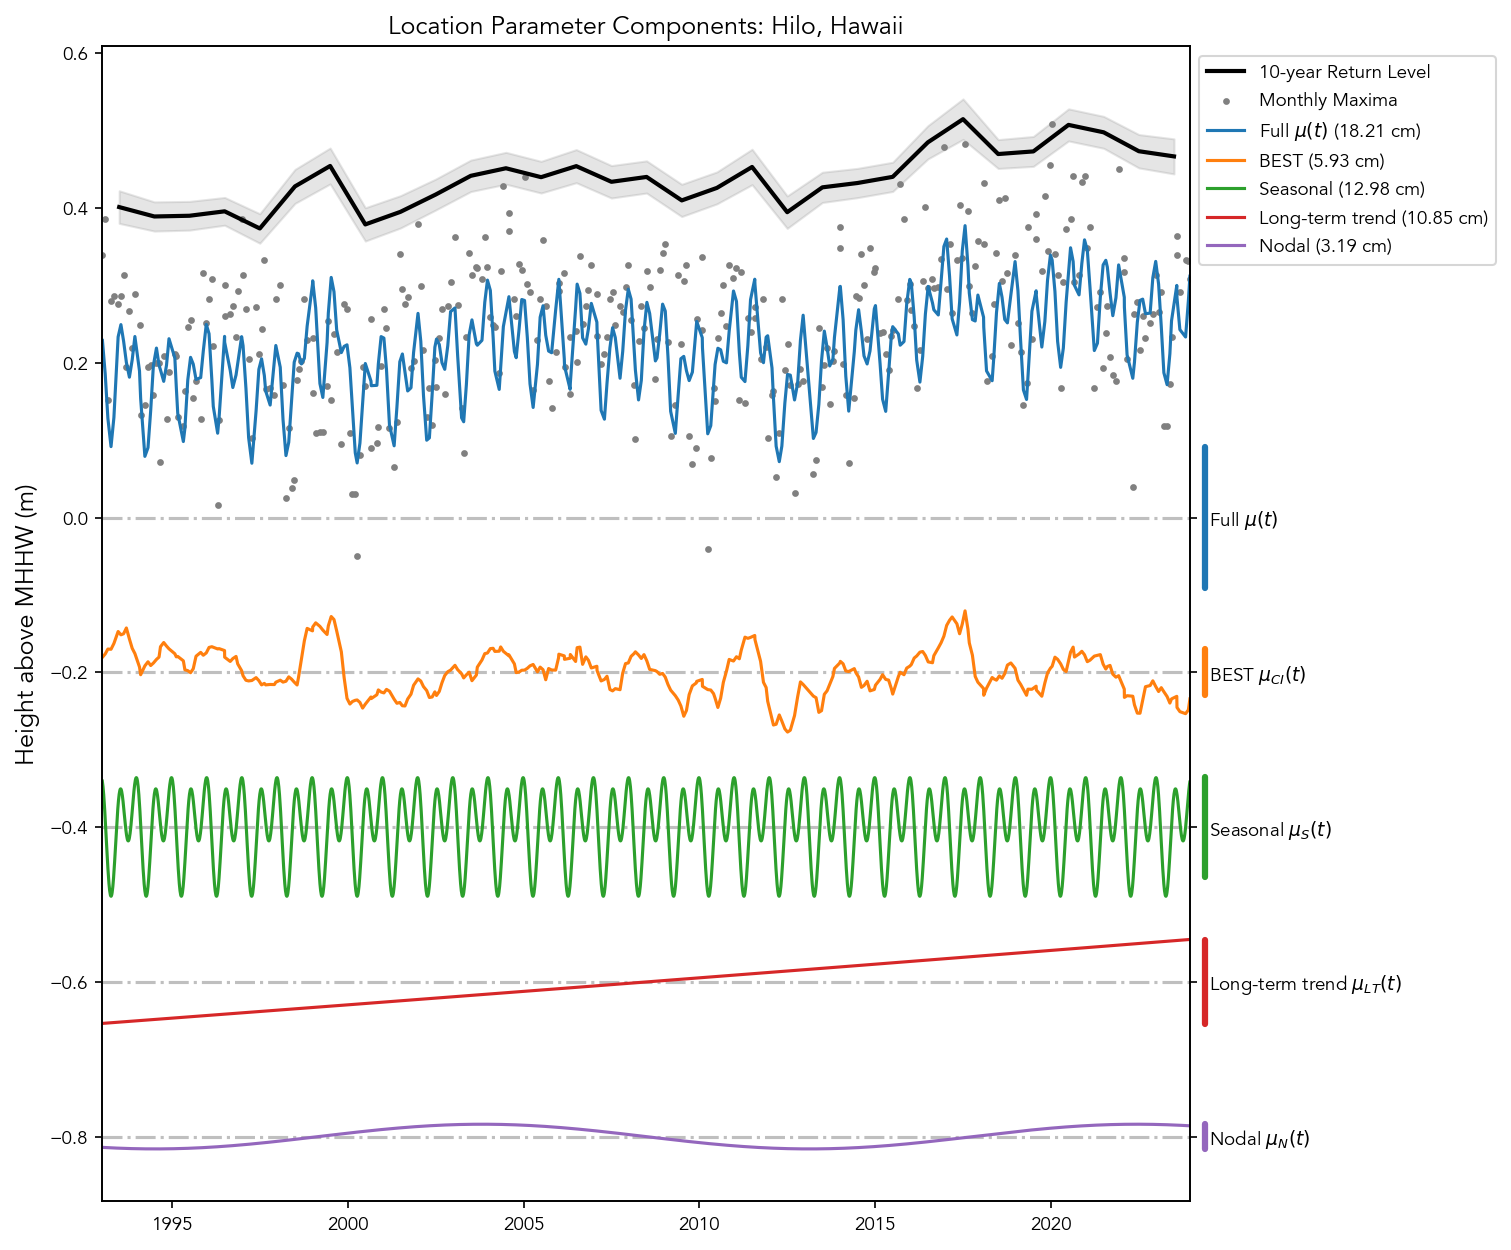

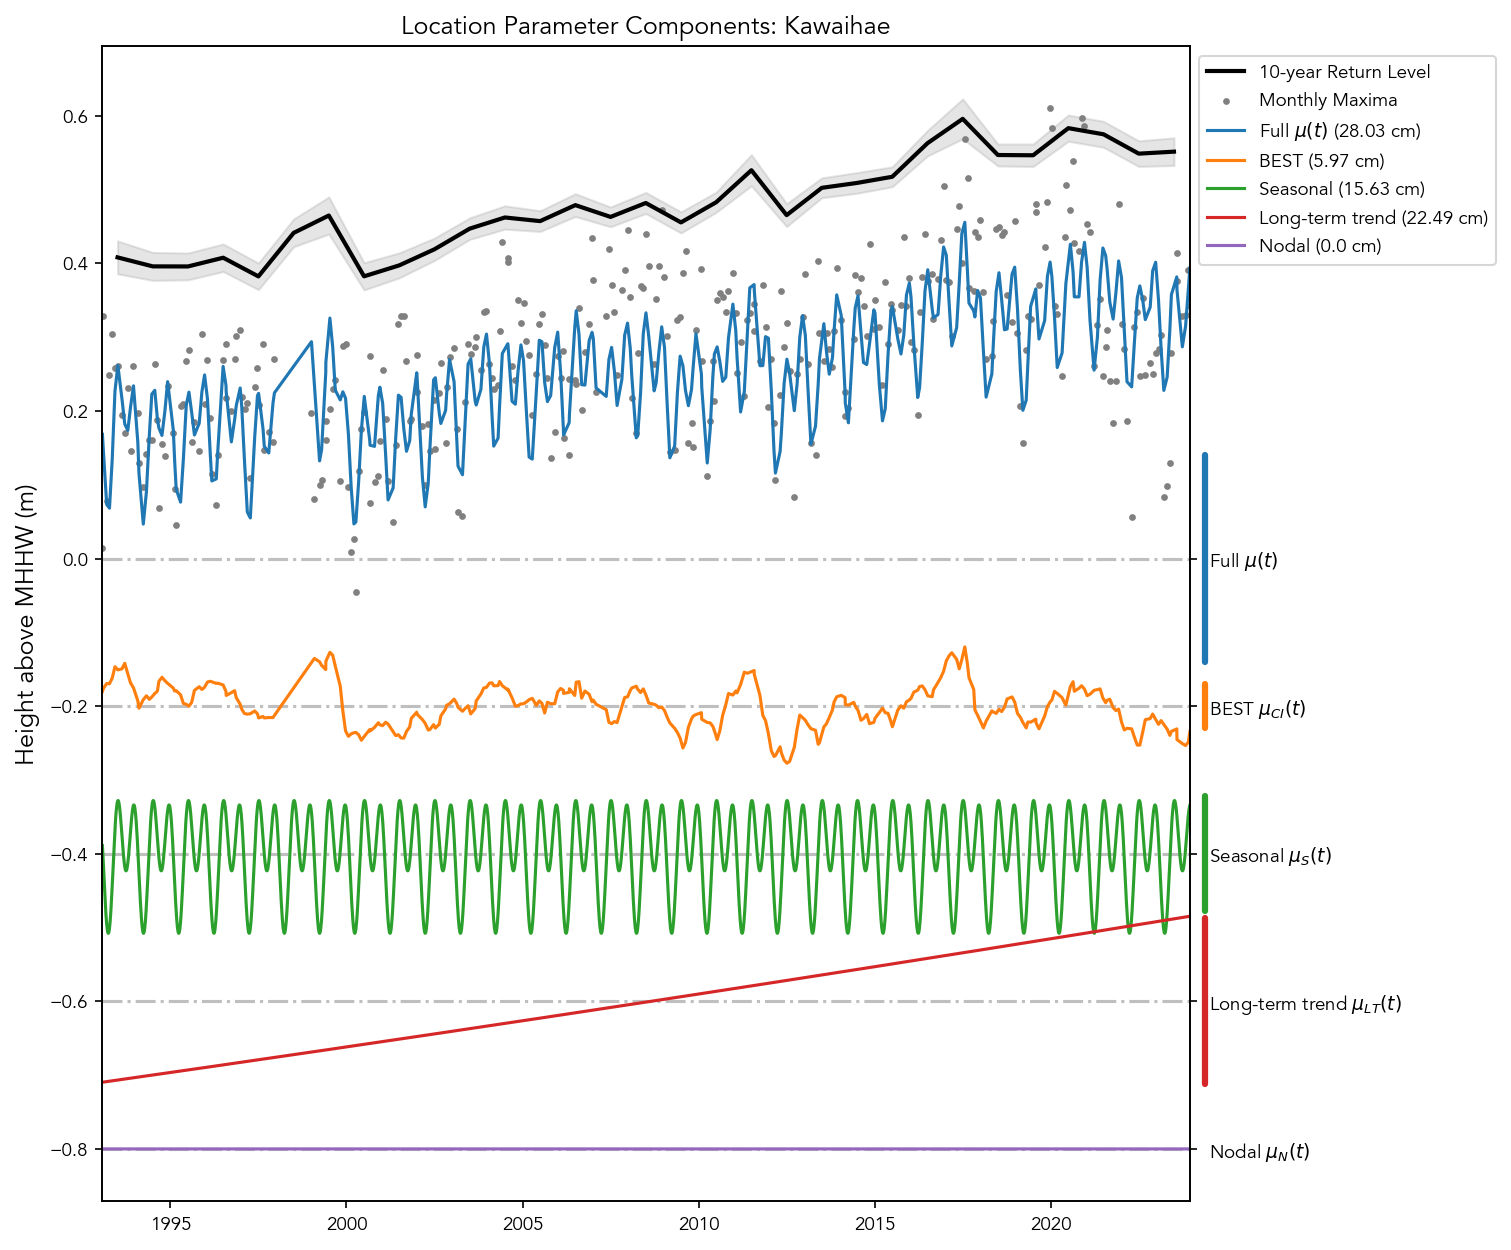

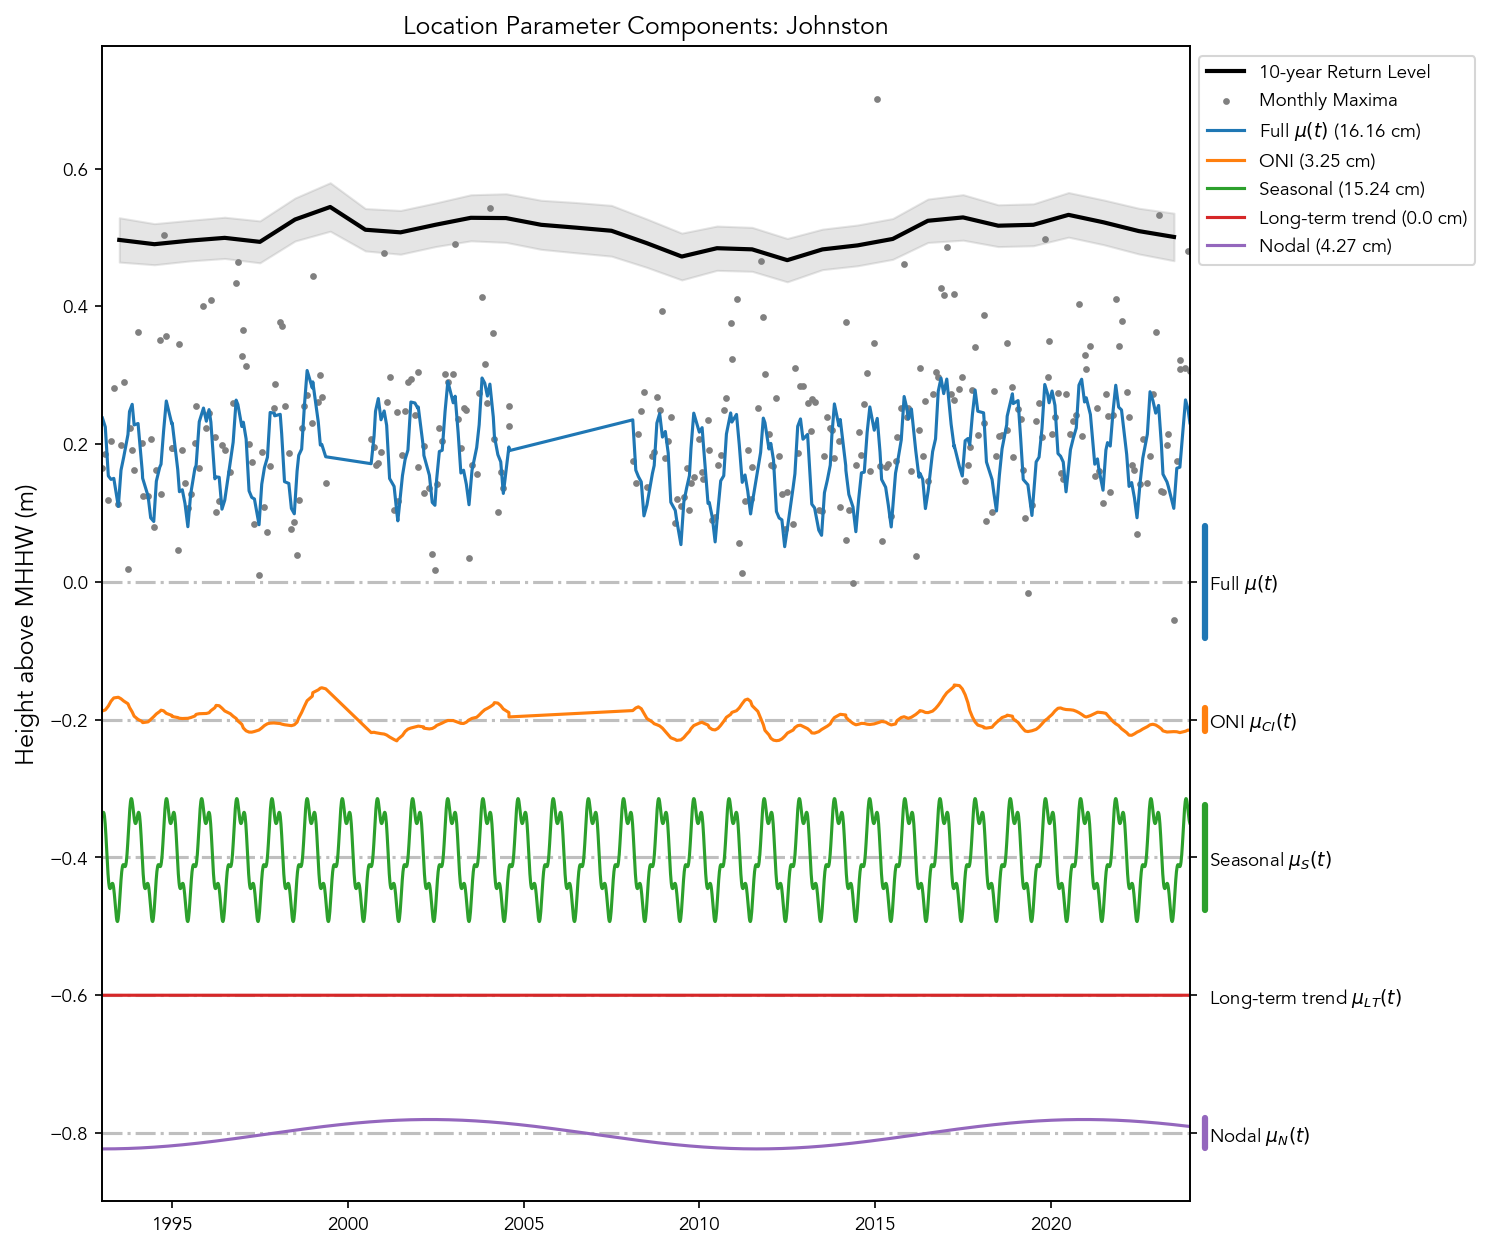

In [10]:
for recordID in recordIDs:

    # read the json file for best model
    jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'best_params.json'
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        modelInfo = output['modelInfo']
        params = output['w']
        x = output['x']
        
    time = modelInfo['year0'] + pd.Series(modelInfo['t'])

    w = adjust_w_for_plotting(x, params)
    modelType = 'RL_best.nc'
    model = xr.open_dataset(Path(dirs['model_output_dir']) / str(recordID) / modelType)
    fig, amps, ax = make_component_figure(w, modelInfo, model, time)

    #save the figure
    savename = 'LocationComponents_' + model.attrs['station_name'] + '.png'
    filename = Path(dirs['output_dir']) / savename
    fig.savefig(filename, bbox_inches='tight')

    # save amps to a json file
    amps_json = Path(dirs['model_output_dir']) / str(recordID) / 'location_param_component_amps.json'
    with open(amps_json, 'w') as f:
        json.dump(amps, f)



Now we'll save the parameter component amplitudes to our model output directory.

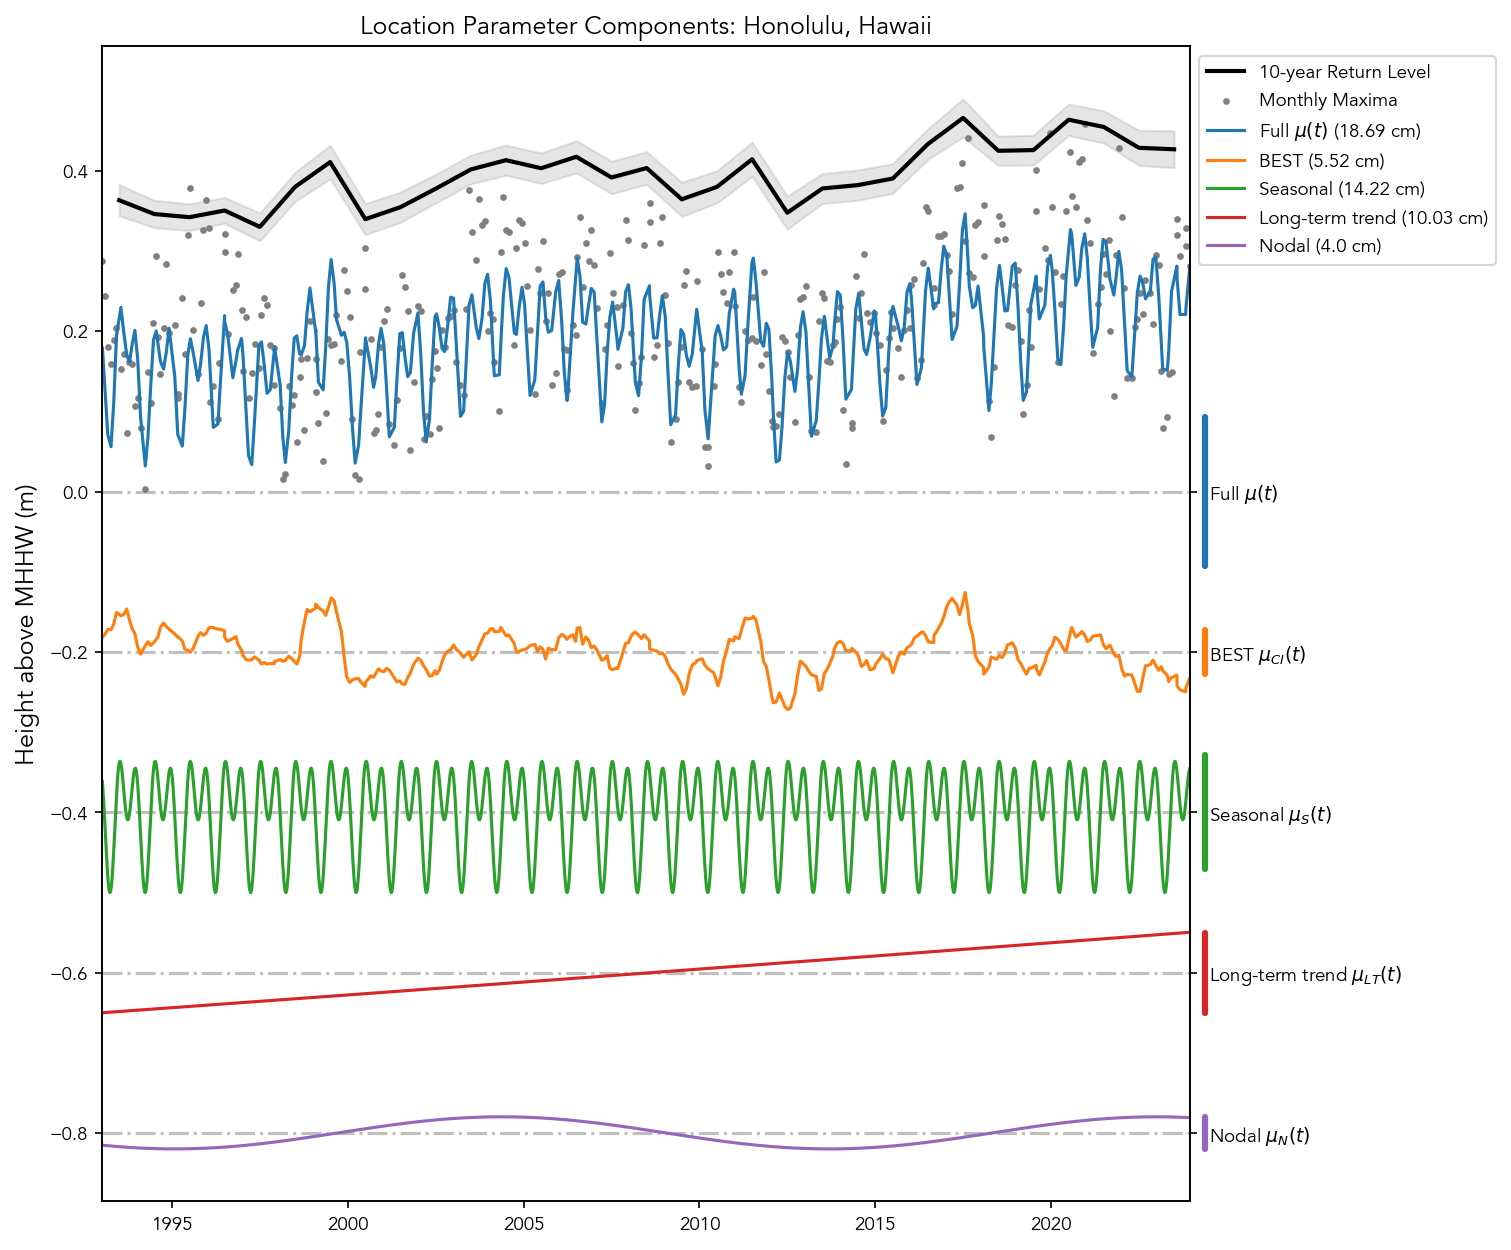

In [11]:
recordID = 57

# read the json file for best model
jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'best_params.json'
with open(jsonpath, 'r') as f:
        output = json.load(f)
        modelInfo = output['modelInfo']
        params = output['w']
        x = output['x']
        
time = modelInfo['year0'] + pd.Series(modelInfo['t'])

w = adjust_w_for_plotting(x, params)
modelType = 'RL_best.nc'
model = xr.open_dataset(Path(dirs['model_output_dir']) / str(recordID) / modelType)
fig, amps, ax = make_component_figure(w, modelInfo, model, time)

glue("location_components",fig,display=False)
glue("station",model.attrs['station_name'],display=False)


```{glue:figure} location_components
:name: "location_components"

Location parameter components for the {glue:text}`station` tide gauge. 
```

### Plot components by station

The following code can only be run after all gauges have been modeled!

In [12]:
# get all location_parms_component_amp.json files and combine them into one
amps = {}

for recordID in recordIDs:
    amps_json = Path(dirs['model_output_dir']) / str(recordID) / 'location_param_component_amps.json'
    with open(amps_json, 'r') as f:
        amps[recordID] = json.load(f)


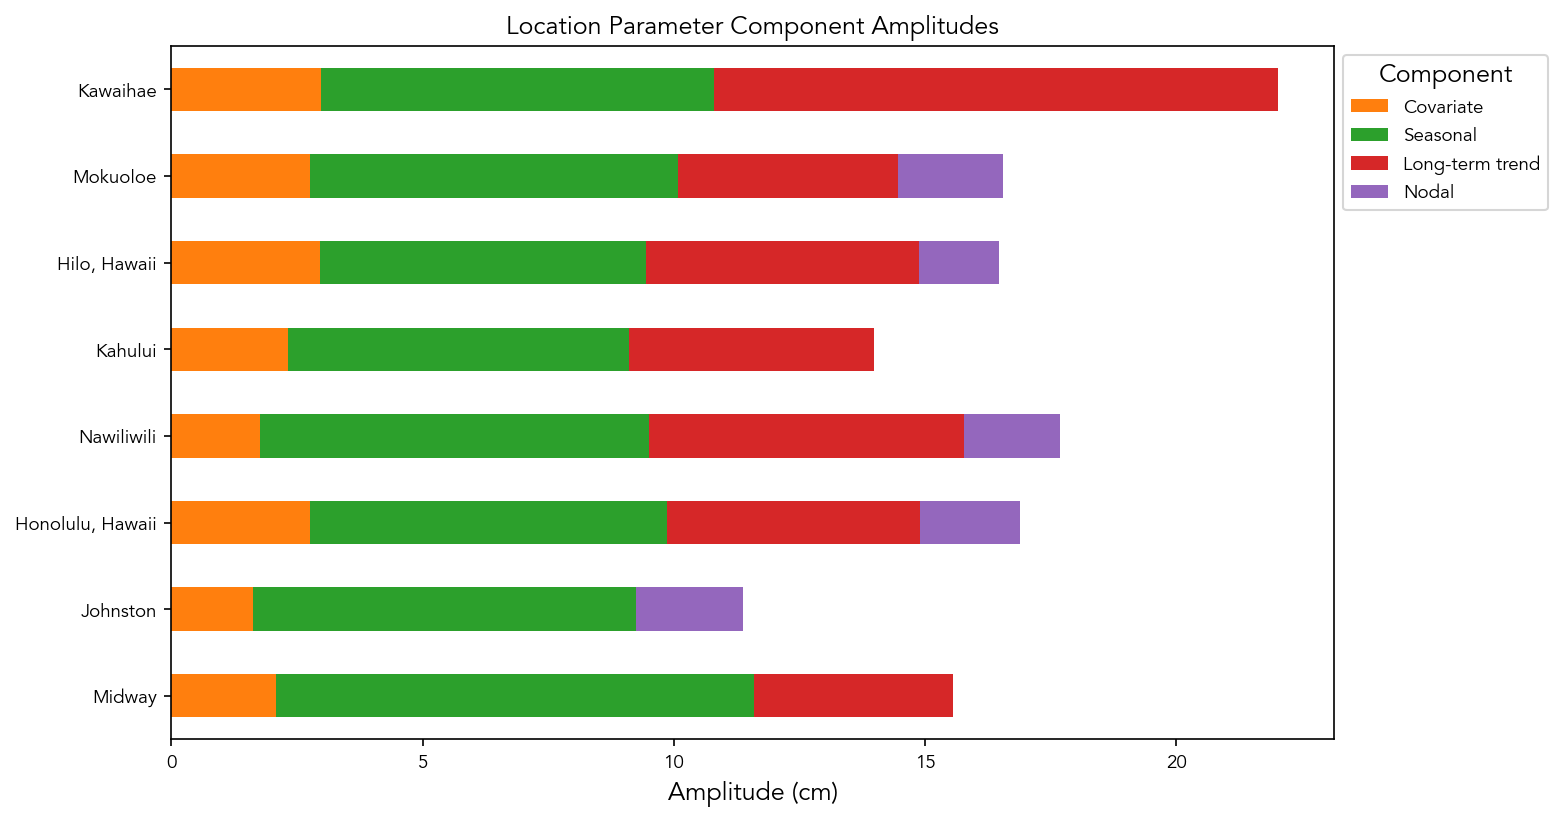

In [13]:
# Plot df as stacked bar chart ignoring the full component
# Turn amps into a dataframe
df = pd.DataFrame(amps).T
df.drop('Full', axis=1,inplace=True)

# Reorder columns to match above plot
df = df[['Covariate','Seasonal', 'Long-term trend',  'Nodal']]
#rename 'Covariate' to 'BEST (19-month lag)'
# df = df.rename(columns={'Covariate':'BEST (19-month lag)'})
df = df.sort_index()

# conver the data colums to cm and round to 2 decimal places
df = df.apply(lambda x: x*100).round(2)

# add station names to the dataframe
df['Station Name'] = station_names.values()


# Plot the data with amplitudes on the x-axis
df.plot(kind='barh', stacked=True, figsize=(10, 6), color=plt.cm.tab10.colors[1:])
plt.title('Location Parameter Component Amplitudes')
plt.xlabel('Amplitude (cm)')
plt.legend(title='Component', loc='upper left', bbox_to_anchor=(1, 1))

# replace the x-axis with the station names
plt.yticks(np.arange(len(df.index)), df['Station Name']);

# save the plot
savename = Path(dirs['output_dir']) / 'location_param_component_amps.png'
plt.savefig(savename, bbox_inches='tight')


### Plot a map
Here we'll look at the influence of the climate covariate in the form of a map. First we'll extract the amplitudes of the covariate from every station we've analyzed.


In [14]:
# load rsl data
with xr.open_dataset(dirs['data_dir'] / 'rsl_daily_hawaii.nc') as rsl:
    df = rsl[['lat', 'lon', 'station_name', 'record_id']].to_dataframe().reset_index()
    pass

# Initialize ampCI as a vector of zeros
df['ampCI'] = 0

# Assign ampCI values using the recordID column with vectorization, where possible
df['ampCI'] = df['record_id'].map(lambda rid: amps.get(rid, {}).get('Covariate', 0))

# Initialize modelCI with 'None' as default
df['modelCI'] = 'None'

# Function to get modelCI, with improved error handling
def get_model_ci(record_id):
    fpath = Path(dirs['model_output_dir']) / str(record_id) / 'RL_best.nc'
    try:
        with xr.open_dataset(fpath) as model:
            return model.attrs.get('covariate', 'None')
    except FileNotFoundError:
        print(f'No model found for recordID: {record_id}, skipping...')
        return 'None'
    except Exception as e:
        print(f'Error processing {record_id}: {e}')
        return 'None'

# Apply the function to the DataFrame (efficient vectorized operation)
df['modelCI'] = df['record_id'].apply(get_model_ci)


No model found for recordID: 14, skipping...
No model found for recordID: 547, skipping...
No model found for recordID: 548, skipping...


Next we'll plot up our map.

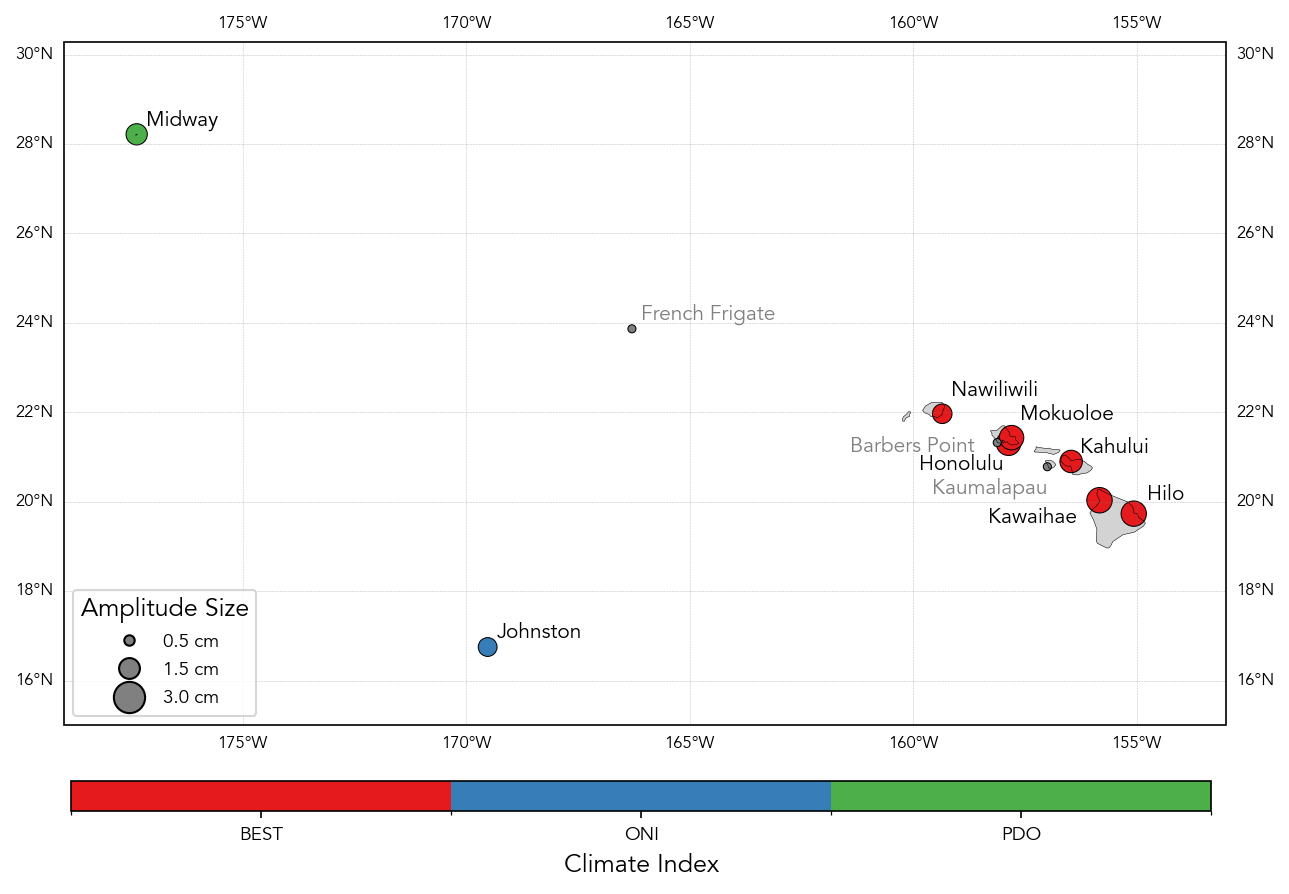

In [15]:
df['ampCI'] = 100*df['ampCI']
df['ampCI'] = df['ampCI'].round(2)

# make all ampCI values if zero 0.05
df['ampCI'] = df['ampCI'].replace(0, 0.3)



# Separate the "None" entries from the rest of the data
df_none = df[df['modelCI'] == 'None']  # Entries where modelCI is 'None'
df_filtered = df[df['modelCI'] != 'None']  # All other entries

# Use tab10 colormap for colors (excluding 'None')
cmap = plt.get_cmap('Set1')
color_dict = {index: cmap(i) for i, index in enumerate(np.unique(df_filtered['modelCI']))}

# Map the climate indices to numerical values for the colorbar
index_mapping = {index: i for i, index in enumerate(np.unique(df_filtered['modelCI']))}
mapped_indices = [index_mapping[ci] for ci in df_filtered['modelCI']]

# Create a colormap without "None"
norm = colors.BoundaryNorm(boundaries=np.arange(len(np.unique(df_filtered['modelCI'])) + 1) - 0.5, 
                               ncolors=len(np.unique(df_filtered['modelCI'])))

fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# # Call plot_thin_map_hawaii to create the figure and axis
plot_thin_map_hawaii(ax)

# Plot each station with varying color (based on climate index) and size (based on amplitude)
scatter = ax.scatter(df_filtered['lon'], df_filtered['lat'], 
                     c=mapped_indices, cmap=cmap, 
                     norm=norm, s=50 * df_filtered['ampCI'],
                     edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

# Plot the "None" stations in gray (fixed color)
ax.scatter(df_none['lon'], df_none['lat'], 
           color='gray', s=50 *df_none['ampCI'], 
           edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

dfInfo = get_stationinfo(dirs['data_dir'])
dfInfo['record_id'] = dfInfo['record_id']

#change the font color to black if the station is in the df_filtered
dfInfo['fontcolor'] = np.where(dfInfo['record_id'].isin(df_filtered['record_id']), 'black', 'gray')

# Add an axes for the colorbar
cax = fig.add_axes([0.13, 0.21, 0.76, 0.02])  

# dfInfo
# Add text labels with adjusted offsets and horizontal alignment
for i, name in enumerate(dfInfo['station_name']):
    ax.text(dfInfo['lon'][i] + dfInfo['offsetlon'][i], dfInfo['lat'][i] + dfInfo['offsetlat'][i], name, 
            ha=dfInfo['ha'][i], fontsize=10, transform=ccrs.PlateCarree(),rotation=0, color = dfInfo['fontcolor'][i])

# Add a colorbar for the climate index
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
cbar.set_ticks(np.arange(len(np.unique(df_filtered['modelCI']))))
cbar.set_ticklabels(np.unique(df_filtered['modelCI']))
cbar.set_label('Climate Index')


# Amplitude size legend
sizes = [50, 100, 150]
size_labels = ["0.5 cm", "1.5 cm", "3.0 cm"]  
size_legend_elements = [Line2D([0], [0], marker='o', color='none', label=label, 
                               markerfacecolor='gray', markersize=size / 10) 
                        for size, label in zip(sizes, size_labels)]
ax.legend(handles=size_legend_elements, title="Amplitude Size", loc="lower left")

# save the figure
savename = Path(dirs['output_dir']) / 'SL_contributions_map.png'
plt.savefig(savename, dpi=300, bbox_inches='tight')

glue("CI_map",fig,display=False)


```{glue:figure} CI_map
:name: "CI_map"

Map of dominant climate indices in the Hawaiian Islands region. The size of each circle at a given tide gauge represents the amplitude of the climate covariate in the location parameter of nonstationary extremes. ENSO-type climate indices are are well-represented with amplitudes between 1.5-3 cm. Here, the lags for ENSO-type indices in the main Hawaiian Islands are set at 18 months, which aligns well with previous literature (e.g. Long et al 2020). 
```

### Plot sub-annual contributions


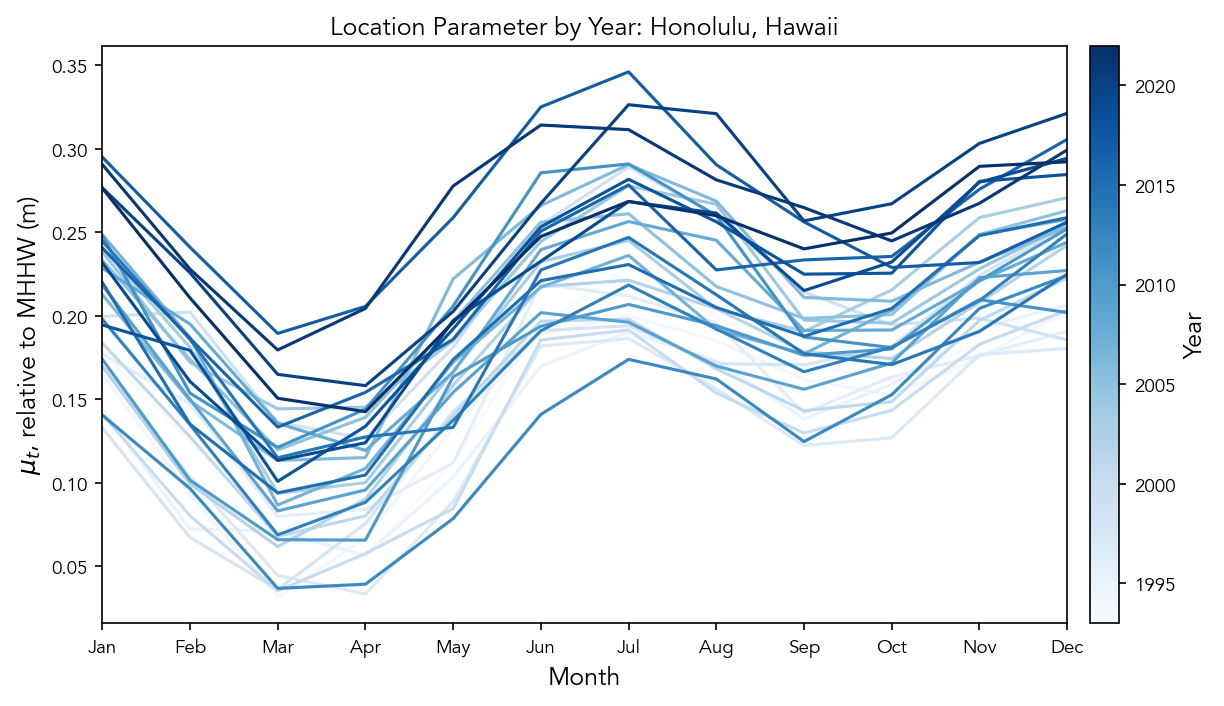

In [16]:
recordID = 57
jsonpath = Path(dirs['model_output_dir']) / str(recordID) / 'best_params.json'
with open(jsonpath, 'r') as f:
    output = json.load(f)
    modelInfo = output['modelInfo']
    params = output['w']
    x = output['x']

w = adjust_w_for_plotting(x, params)    

# params should be a dictionary with the following
paramNames = ['b0','a0','g0','b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'bLT', 'bCI', 'cCI', 'bN1', 'bN2']
params = {paramNames[i]: w[i] for i in range(len(paramNames))}

t = np.array(modelInfo['t'])
ci = np.array(modelInfo['covariate'])
# Convert t to years
tyears = t + modelInfo['year0']

# Constants
api = np.pi # pi
ak = 2 * api # 2pi
ak18 = 2 * api / 18.61  # 18.61-year nodal cycle

mut = (params['b0'] * np.exp(params['bLT'] * t) +
        params['b1'] * np.cos(ak * t) + params['b2'] * np.sin(ak * t) +
        params['b3'] * np.cos(2 * ak * t) + params['b4'] * np.sin(2 * ak * t) +
        params['b5'] * np.cos(4 * ak * t) + params['b6'] * np.sin(4 * ak * t) +
        params['bN1'] * np.cos(ak18 * t) + params['bN2'] * np.sin(ak18 * t) +
        params['bCI'] * ci)

mut = mut - modelInfo['STNDtoMHHW']


tfrac = t-np.floor(t)

import calendar
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

t00 = np.arange(1993,2023)
# make colormap the same length as t00
cmap = plt.cm.Blues(np.linspace(0,1,len(t00)))
# plt.plot(tyears(np.floor(tyears)==t00),mut[np.floor(tyears)==t00])
for t0 in t00:
    inYear = np.floor(tyears).astype(int) == t0
    color_index = np.where(t00 == t0)[0][0]  # Find the index of t0 in t00
    plt.plot(np.arange(0, 1, 1/12), mut[inYear], label=str(t0), color=cmap[color_index])

# xlim([0,1])
# set the xlimits to 0 and 1
plt.xlim(0,1-1/12)
# set the xticks to be the months
plt.xticks(np.arange(0, 1, 1/12), [calendar.month_abbr[i] for i in range(1, 13)])
plt.xlabel('Month')
plt.ylabel('$\mu_t$, relative to MHHW (m)')
plt.title('Location Parameter by Year: ' + modelInfo['station_name'])


sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=t00.min(), vmax=t00.max()))
cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', pad=0.02)
cbar.set_label('Year')

glue("location_by_year",fig,display=False)
savename = 'location_by_year_' + modelInfo['station_name'] + '.png'
plt.savefig(output_dir / savename, dpi=300, bbox_inches='tight')

#glue the CI name
glue("CI_name",modelInfo['covariateName'],display=False)
glue("station",modelInfo['station_name'],display=False)

# get lag for covariateName
df_cvteLocation = pd.read_json(Path(dirs['model_output_dir']) / str(recordID) / 'cvte_location_params_ALL.json')

CI_lag = df_cvteLocation[df_cvteLocation['Climate Index'] == modelInfo['covariateName']]['lag'].values[0]
glue("CI_lag",CI_lag,display=False)

```{glue:figure} location_by_year
:name: "location_by_year"

This plot shows the changes in the location parameter (with covariate included) from 1993 through 2023 for the non-stationary GEV model at {glue:text}`station`. This particular calculation uses the {glue:text}`CI_name` climate index at a {glue:text}`CI_lag`-month lag. While there is a steady trend (background sea level rise), this is also affected by the covariate and nodal influences.
```


---

### Citations

```{bibliography}
:style: plain
:filter: docname in docnames
```